# Test Cell: Keeps my edits after I merge Ben's

Business Question Brainstorm:
- Cost of Plane
- Personal vs. Commercial
- Spatial:  
           - United States:
                    - Can use lat/long to look at geography 
           - International vs US
           - Developed vs. Developing (and temporal?)


Data Cleaning List:
- Subset by time period
- Subset into developed vs. developing - before and after developing, then developed
- Remove dupes based on Event.id

## Import Packages and Read in Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


pd.set_option('display.max_columns', None)
import pandas.api.types as ptypes

# To suppress a warning when you do something like this:
    # df_clean1['Make'] = df_clean1['Make'].str.strip()
    # The warning is:
        # <ipython-input-26-b7ee92eb377b>:3: SettingWithCopyWarning: 
        # A value is trying to be set on a copy of a slice from a DataFrame.
        # Try using .loc[row_indexer,col_indexer] = value instead
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
df = pd.read_csv("project_data/Aviation_Data.csv", delimiter=",")
#finalProjectPhase01/Avation_Safety_Data_Analysis/data/AviationData.csv

/Users/claire/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (6,7,28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Initial Data Exploration

In [3]:
df.head()

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,Injury.Severity,Aircraft.damage,Aircraft.Category,Registration.Number,Make,Model,Amateur.Built,Number.of.Engines,Engine.Type,FAR.Description,Schedule,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,Fatal(2),Destroyed,NaN,NC6404,Stinson,108-3,No,1.0,Reciprocating,NaN,NaN,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,Fatal(4),Destroyed,NaN,N5069P,Piper,PA24-180,No,1.0,Reciprocating,NaN,NaN,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.9222,-81.8781,NaN,NaN,Fatal(3),Destroyed,NaN,N5142R,Cessna,172M,No,1.0,Reciprocating,NaN,NaN,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,Fatal(2),Destroyed,NaN,N1168J,Rockwell,112,No,1.0,Reciprocating,NaN,NaN,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,Fatal(1),Destroyed,NaN,N15NY,Cessna,501,No,NaN,NaN,NaN,NaN,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90348 entries, 0 to 90347
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      90348 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50249 non-null  object 
 9   Airport.Name            52790 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87572 non-null  object 
 14  Make                    88826 non-null

## Convert Event.Date to Date Type

In [5]:
# Coerce 'Event.Date' into pandas date time object
df["Event.Date"] = pd.to_datetime(df['Event.Date'], format='%Y-%m-%d', errors = 'coerce')
# Assert that Event.Date is not a datetime64 dtype:
assert ptypes.is_datetime64_any_dtype(df['Event.Date'])



## Clean Event.Id Column
### This removes nulls from Event.Id, Investigation.Type, Accident.Number, and Event.Date

In [6]:
# Drop rows where 'Event.Id' is NULL
df_clean = df.dropna(subset=['Event.Id'])


In [7]:
# Drop duplicates using the Event.Id column
df_clean1 = df_clean.drop_duplicates(subset=['Event.Id'])


In [8]:
# After dropping rows where NOT Event.Id null,
# We now have a dataset where first 4 columns have no nulls
# We think this makes sense because without an id or accident number, the event wasn't properly documented
df_clean.isna().sum()

Event.Id                      0
Investigation.Type            0
Accident.Number               0
Event.Date                    0
Location                     52
Country                     226
Latitude                  54507
Longitude                 54516
Airport.Code              38640
Airport.Name              36099
Injury.Severity            1000
Aircraft.damage            3194
Aircraft.Category         56602
Registration.Number        1317
Make                         63
Model                        92
Amateur.Built               102
Number.of.Engines          6084
Engine.Type                7077
FAR.Description           56866
Schedule                  76307
Purpose.of.flight          6192
Air.carrier               72241
Total.Fatal.Injuries      11401
Total.Serious.Injuries    12510
Total.Minor.Injuries      11933
Total.Uninjured            5912
Weather.Condition          4492
Broad.phase.of.flight     27165
Report.Status              6381
Publication.Date          15230
dtype: i

# Subset based on Event.Date
- We wanted to only look at past 30 years because planes older than that likely no longer flying

In [9]:
# Subset data to look at past 30 years of data:
df_30 = df_clean[df_clean['Event.Date'] >= '1993-01-01']

In [10]:
# Check Date Range
print(df_30['Event.Date'].min())
print(df_30['Event.Date'].max())


1993-01-01 00:00:00
2022-12-29 00:00:00


# Create Total Injuries Column

In [11]:
# Create Total Injuries Column
df_30['Total.Injuries'] = df_30['Total.Fatal.Injuries'] + df_30['Total.Minor.Injuries'] + df_30['Total.Serious.Injuries'] 
# Sanity Check new 'Total.Injuries' Column:
df_30[['Total.Injuries', 'Total.Fatal.Injuries', 'Total.Minor.Injuries', 'Total.Serious.Injuries']].head()

,Total.Injuries,Total.Fatal.Injuries,Total.Minor.Injuries,Total.Serious.Injuries
32026,2.0,1.0,1.0,0.0
32027,1.0,0.0,0.0,1.0
32028,1.0,0.0,1.0,0.0
32029,1.0,0.0,1.0,0.0
32030,0.0,0.0,0.0,0.0


# Clean Make and Model Columns

In [12]:
#Cleaning the Make column (this gets rid of a lot of unique values)
#Start by making everything lowercase
df_clean1['Make'] = df_clean1['Make'].str.lower()
#capitalize the beginning of each word
df_clean1['Make'] = df_clean1['Make'].str.title()
#Get rid of whitespace
df_clean1['Make'] = df_clean1['Make'].str.strip()

In [13]:
#Cleaning the Model column (I don’t think this got rid of any unique values)
#Start by making everything uppercase
df_clean1['Model'] = df_clean1['Model'].str.upper()
#Get rid of whitespace
df_clean1['Model'] = df_clean1['Model'].str.strip()

In [14]:
df_clean1['Model']

0            108-3
1         PA24-180
2             172M
3              112
4              501
           ...    
90343    PA-28-151
90344         7ECA
90345        8GCBC
90346         210N
90347    PA-24-260
Name: Model, Length: 87951, dtype: object

# Clean Aircraft.Category Column:
- Here we will throw out only those Aircraft.Category rows where Airplane or NULL
- Concatenate Make and Model = Make_Model
- Keep the rows that are (Aircraft.Category = NULL) ONLY IF...
- The Make_Model value is one that exists in rows that are (Aircraft.Category = 'Airplane')

In [15]:
#Get rid of non airplane rows but keep the nulls
#First fill nulls with ‘n/a’
df_clean1['Aircraft.Category'].fillna('n/a', inplace=True)
#Keep only rows with ‘Airplane’ or ‘n/a’
df_clean2 = df_clean1.loc[(df_clean1['Aircraft.Category'] == 'Airplane') | (df_clean1['Aircraft.Category'] == 'n/a')]


In [16]:
df_clean2['Aircraft.Category'].value_counts()

n/a         55770
Airplane    27520
Name: Aircraft.Category, dtype: int64

In [17]:
# Create concatenated Make.Model column:
df_clean2["Make.Model"] = df_clean2['Make'].astype(str) +"_"+ df_clean2["Model"]

In [18]:
df_clean2["Make.Model"].head()

0     Stinson_108-3
1    Piper_PA24-180
2       Cessna_172M
3      Rockwell_112
4        Cessna_501
Name: Make.Model, dtype: object

In [19]:
# Preview counts for each Make.Model, grouped on Aircraft.Category:
df_clean2.groupby(['Aircraft.Category','Make.Model']).size()


Aircraft.Category  Make.Model                 
Airplane           177Mf Llc_PITTS MODEL 12       1
                   2007 Savage Air Llc_EPIC LT    1
                   2021Fx3 Llc_CCX-2000           2
                   3Xtrim_450 ULTRA               1
                   5 Rivers Llc_SQ-2              1
                                                 ..
n/a                nan_RV-4                       1
                   nan_SUPER QUICKIE 2            1
                   nan_TERATORN                   1
                   nan_UNKNOWN                    1
                   nan_VANS RV-6                  1
Length: 18520, dtype: int64

### Split into two dataframes:

In [20]:
# Isolate a dataframe only containing rows where category is Airplane:
df_plane = df_clean2[df_clean2['Aircraft.Category'] == 'Airplane']
# And one for category = n/a:
df_na = df_clean2[df_clean2['Aircraft.Category'] == 'n/a']

### Explore results:

In [21]:
# Category = Airplane

# 27,520 rows
# 7,484 unique Make.Model values
print(df_plane.shape)
print(df_plane['Make.Model'].unique().shape)
df_plane['Make.Model'].tail()

(27520, 32)
(7484,)


90328                          Piper_PA42
90332             Cirrus Design Corp_SR22
90335                  Swearingen_SA226TC
90336                        Cessna_R172K
90345    American Champion Aircraft_8GCBC
Name: Make.Model, dtype: object

In [22]:
# Category = n/a

# 55,770 rows
# 11,038 unique Make.Model values
print(df_na.shape)
print(df_na['Make.Model'].unique().shape)
df_na['Make.Model'].tail()

(55770, 32)
(11038,)


90342    Air Tractor_AT502
90343      Piper_PA-28-151
90344        Bellanca_7ECA
90346          Cessna_210N
90347      Piper_PA-24-260
Name: Make.Model, dtype: object

### Filter the **category = n/a** rows to only contain the Make.Model values of Airplanes

In [23]:
# Get a list of all of the unique values of "Make.Model" where aircraft.category = 'Aiplane':
airplane_make_model_list = list(df_plane['Make.Model'].unique())

In [24]:
# Go back to original dataframe "df_clean2" before we split it, and filter to only Make.Model values in airplane_make_model_list
df_ap_mm = df_clean2[df_clean2['Make.Model'].isin(airplane_make_model_list)]

In [25]:
# Sanity Check:
# Number of rows where 'Aircraft.Category' = 'Airplane' vs. Total Rows
print(df_ap_mm['Aircraft.Category'].value_counts())
print(df_ap_mm.shape)

n/a         39923
Airplane    27520
Name: Aircraft.Category, dtype: int64
(67443, 32)


### Now we only have Make.Model rows that we know are Airplanes, so we can replace all 'n/a' values with 'Airplane'

In [26]:
# Fill 'n/a' value with 'Airplane':
df_ap_mm['Aircraft.Category'] = df_ap_mm['Aircraft.Category'].replace(['n/a'], 'Airplane')


# Scratch

In [27]:
# Is accident number unique?
#Accident.Number
df_ap_mm['Accident.Number'].is_unique

True

# Analyze Makes, Models, and Purpose of Flight

### Airplane Makes with the most accidents - Top 10

In [28]:
# See all values of Make and Model for our airplanes:
df_ap_mm['Make'].value_counts()

Cessna                          26238
Piper                           14336
Beech                            4817
Boeing                           2193
Mooney                           1250
                                ...  
Avery Jack H                        1
Arvold Jordon R                     1
Cessna Skyhawk Ii                   1
Grumman American Corporation        1
Polcyn                              1
Name: Make, Length: 3547, dtype: int64

Text(0, 0.5, 'Number of Accidents')

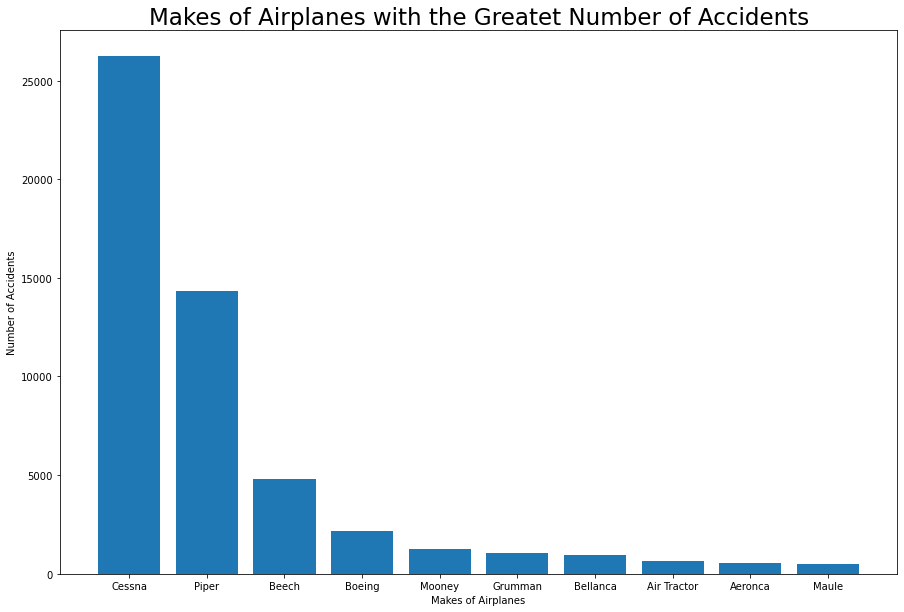

In [29]:
# Top 10 makes of airplanes that had a crash in the last 30 years:

airplane_makes = list(df_ap_mm['Make'].value_counts()[0:10].index)
accident_counts = list(df_ap_mm['Make'].value_counts()[0:10].values)


bar_chart_title = 'Makes of Airplanes with the Greatet Number of Accidents'
bar_chart_count_label = 'Makes of Airplanes'
bar_chart_series_label = 'Number of Accidents'

fig, ax= plt.subplots(figsize=(15, 10))

ax.set_title(bar_chart_title, fontsize=23)

ax.bar(x=airplane_makes, height=accident_counts)

ax.set_xlabel(bar_chart_count_label)

ax.set_ylabel(bar_chart_series_label)


Text(0, 0.5, 'Number of Accidents')

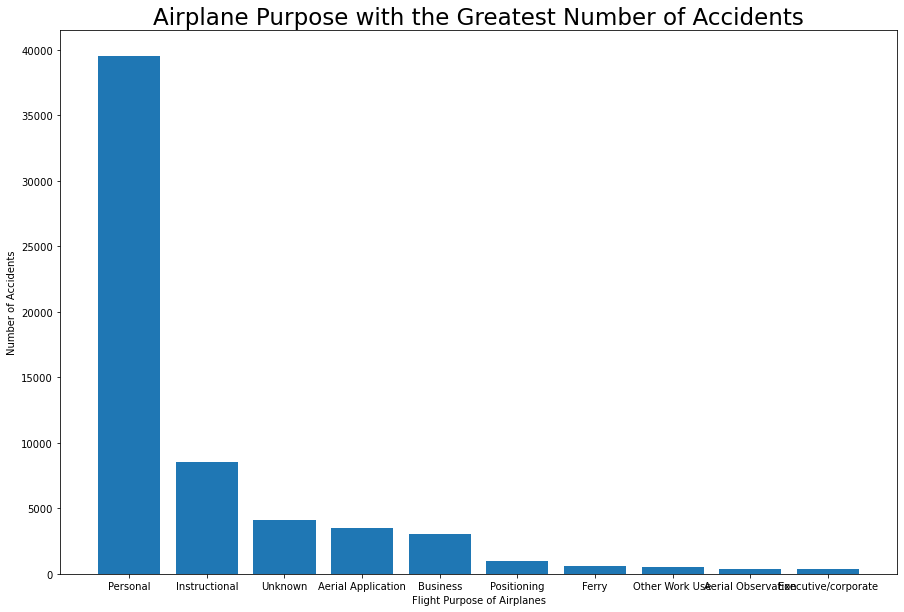

In [30]:
# Top 10 makes of airplanes that had a crash in the last 30 years:

airplane_makes = list(df_ap_mm['Purpose.of.flight'].value_counts()[0:10].index)
accident_counts = list(df_ap_mm['Purpose.of.flight'].value_counts()[0:10].values)


bar_chart_title = 'Airplane Purpose with the Greatest Number of Accidents'
bar_chart_count_label = 'Flight Purpose of Airplanes'
bar_chart_series_label = 'Number of Accidents'

fig, ax= plt.subplots(figsize=(15, 10))

ax.set_title(bar_chart_title, fontsize=23)

ax.bar(x=airplane_makes, height=accident_counts)

ax.set_xlabel(bar_chart_count_label)

ax.set_ylabel(bar_chart_series_label)

Text(0, 0.5, 'Number of Accidents')

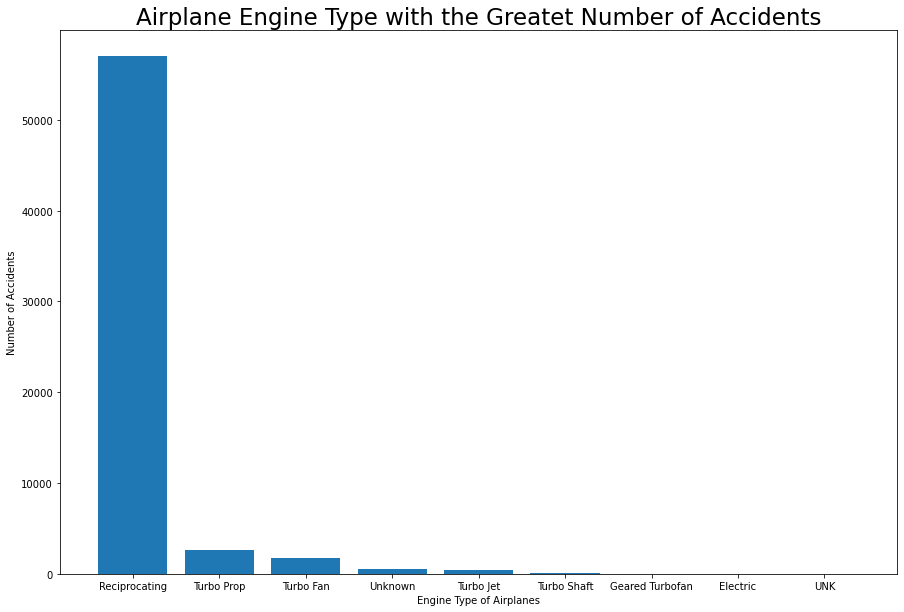

In [31]:
# Top 10 makes of airplanes that had a crash in the last 30 years:

airplane_makes = list(df_ap_mm['Engine.Type'].value_counts()[0:10].index)
accident_counts = list(df_ap_mm['Engine.Type'].value_counts()[0:10].values)


bar_chart_title = 'Airplane Engine Type with the Greatet Number of Accidents'
bar_chart_count_label = 'Engine Type of Airplanes'
bar_chart_series_label = 'Number of Accidents'

fig, ax= plt.subplots(figsize=(15, 10))

ax.set_title(bar_chart_title, fontsize=23)

ax.bar(x=airplane_makes, height=accident_counts)

ax.set_xlabel(bar_chart_count_label)

ax.set_ylabel(bar_chart_series_label)

In [32]:

print(df_ap_mm['Purpose.of.flight'].value_counts())

Personal                     39500
Instructional                 8514
Unknown                       4090
Aerial Application            3489
Business                      3058
Positioning                   1001
Ferry                          591
Other Work Use                 535
Aerial Observation             394
Executive/corporate            380
Public Aircraft                284
Flight Test                    268
Skydiving                      177
Banner Tow                      99
Air Race show                   74
Public Aircraft - Federal       65
Glider Tow                      39
Public Aircraft - State         29
Firefighting                    20
Air Race/show                   16
Public Aircraft - Local         12
ASHO                             5
Air Drop                         5
PUBS                             3
External Load                    1
Name: Purpose.of.flight, dtype: int64


In [33]:
df_ap_mm.head(10)

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,Injury.Severity,Aircraft.damage,Aircraft.Category,Registration.Number,Make,Model,Amateur.Built,Number.of.Engines,Engine.Type,FAR.Description,Schedule,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date,Make.Model
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,Fatal(2),Destroyed,Airplane,NC6404,Stinson,108-3,No,1.0,Reciprocating,NaN,NaN,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN,Stinson_108-3
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.9222,-81.8781,NaN,NaN,Fatal(3),Destroyed,Airplane,N5142R,Cessna,172M,No,1.0,Reciprocating,NaN,NaN,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007,Cessna_172M
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,Fatal(2),Destroyed,Airplane,N1168J,Rockwell,112,No,1.0,Reciprocating,NaN,NaN,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000,Rockwell_112
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,Fatal(1),Destroyed,Airplane,N15NY,Cessna,501,No,NaN,NaN,NaN,NaN,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980,Cessna_501
5,20170710X52551,Accident,NYC79AA106,1979-09-17,"BOSTON, MA",United States,42.4453,-70.7583,NaN,NaN,Non-Fatal,Substantial,Airplane,CF-TLU,Mcdonnell Douglas,DC9,No,2.0,Turbo Fan,Part 129: Foreign,SCHD,NaN,Air Canada,NaN,NaN,1.0,44.0,VMC,Climb,Probable Cause,19-09-2017,Mcdonnell Douglas_DC9
6,20001218X45446,Accident,CHI81LA106,1981-08-01,"COTTON, MN",United States,NaN,NaN,NaN,NaN,Fatal(4),Destroyed,Airplane,N4988E,Cessna,180,No,1.0,Reciprocating,NaN,NaN,Personal,NaN,4.0,0.0,0.0,0.0,IMC,Unknown,Probable Cause,06-11-2001,Cessna_180
7,20020909X01562,Accident,SEA82DA022,1982-01-01,"PULLMAN, WA",United States,NaN,NaN,NaN,BLACKBURN AG STRIP,Non-Fatal,Substantial,Airplane,N2482N,Cessna,140,No,1.0,Reciprocating,Part 91: General Aviation,NaN,Personal,NaN,0.0,0.0,0.0,2.0,VMC,Takeoff,Probable Cause,01-01-1982,Cessna_140
8,20020909X01561,Accident,NYC82DA015,1982-01-01,"EAST HANOVER, NJ",United States,NaN,NaN,N58,HANOVER,Non-Fatal,Substantial,Airplane,N7967Q,Cessna,401B,No,2.0,Reciprocating,Part 91: General Aviation,NaN,Business,NaN,0.0,0.0,0.0,2.0,IMC,Landing,Probable Cause,01-01-1982,Cessna_401B
10,20020909X01559,Accident,FTW82DA034,1982-01-01,"HOBBS, NM",United States,NaN,NaN,NaN,NaN,Non-Fatal,Substantial,Airplane,N44832,Piper,PA-28-161,No,1.0,Reciprocating,NaN,NaN,Personal,NaN,0.0,0.0,0.0,1.0,VMC,Approach,Probable Cause,01-01-1982,Piper_PA-28-161
11,20020909X01558,Accident,ATL82DKJ10,1982-01-01,"TUSKEGEE, AL",United States,NaN,NaN,NaN,TUSKEGEE,Non-Fatal,Substantial,Airplane,N4275S,Beech,V35B,No,1.0,Reciprocating,NaN,NaN,Personal,NaN,0.0,0.0,0.0,1.0,VMC,Landing,Probable Cause,01-01-1982,Beech_V35B


# Columns to explore more closely:

#Make
#Model
#Air.carrier	
#Purpose.of.flight
#Engine.Type	

#Number.of.Engines

#Amateur.Built


1. Dig into 'Purpose.of.flight': 
   a. Personal (39500) vs. summing all other categories
   b. In Tableau, show with stacked bar within the "Accidents by Make" graph -- 
      are some of the most accident prone makes actually looking like that just because they are mostly used for personal flights?
   c. Note: Cessna, Piper and Beech only make small planes
   d. Potential finding is "Don't go into private enterprise but if you do, use this plane"
2. Engine size
   a. Look at Personal Use planes and see number of engines
   Number.of.Engines	
   Engine.Type              

In [34]:
df_ap_mm['Air.carrier'].value_counts()

Pilot                    232
United Airlines           75
American Airlines         72
Delta Air Lines           48
SOUTHWEST AIRLINES CO     41
                        ... 
Air Nostrum                1
Ronald Noland              1
Chipford Pty Ltd           1
BIL MAR FOODS INC DBA      1
Neil T. Wallace            1
Name: Air.carrier, Length: 10928, dtype: int64

# Correlation Matrix

In [35]:
df_corr = df_ap_mm[['Make','Model','Purpose.of.flight', 'Engine.Type', 'Number.of.Engines']]


# Stacked Bar Chart

In [ ]:
df_stacked = pd.pivot_table(data=df_ap_mm, index=['Purpose.of.flight'], columns=['Model'], values='Counts')

# Top 10 makes of airplanes that had a crash in the last 30 years:

airplane_makes = list(df_ap_mm['Purpose.of.flight'].value_counts()[0:10].index)
accident_counts = list(df_ap_mm['Purpose.of.flight'].value_counts()[0:10].values)


bar_chart_title = 'Airplane Purpose with the Greatest Number of Accidents'
bar_chart_count_label = 'Flight Purpose of Airplanes'
bar_chart_series_label = 'Number of Accidents'

fig, ax= plt.subplots(figsize=(15, 10))

ax.set_title(bar_chart_title, fontsize=23)

ax.bar(x=airplane_makes, height=accident_counts)

ax.set_xlabel(bar_chart_count_label)

ax.set_ylabel(bar_chart_series_label)